# Assumption:

The $\lambda$-CDM model assumes:
1. Flat Universe: The curvature parameter will be zero, which is $\Omega_{k}=0$
2. Expanding Universe

## Reading the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = np.loadtxt('/content/drive/MyDrive/DDP/Data/sn_z_mu_dmu_plow_union2.1.txt', usecols=(1,2,3))

In [ ]:
data = data[data[:,0].argsort()]

In [ ]:
z_data = data[:,0]
mu_data = data[:,1]
mu_error_data = data[:,2]

Plotting the data

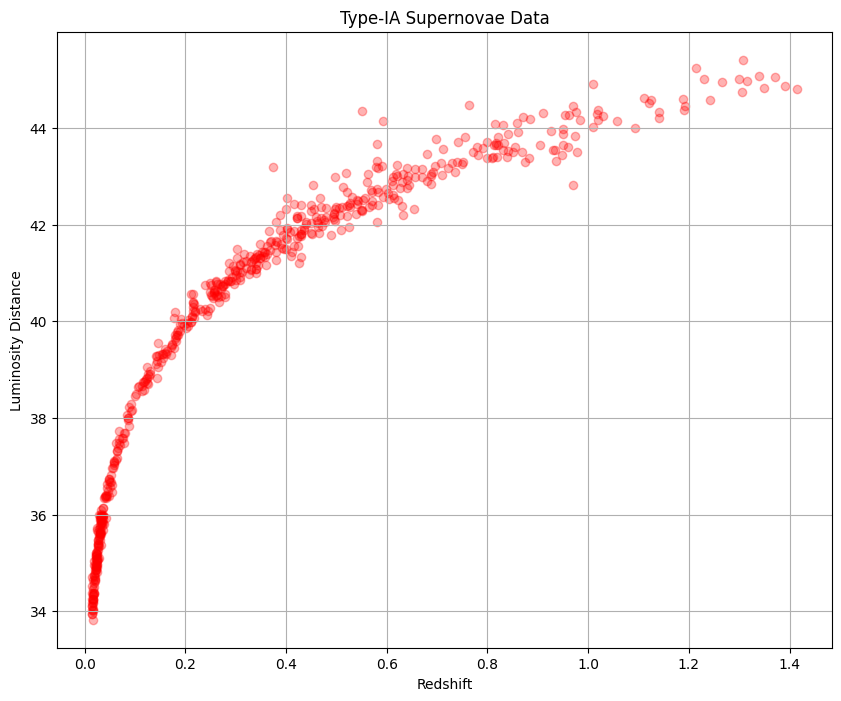

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(z_data, mu_data, color='red',alpha=0.3)
plt.xlabel('Redshift')
plt.ylabel('Luminosity Distance')
plt.title('Type-IA Supernovae Data')
plt.grid(visible='True')

## Creating the model

In [ ]:
# Defining params and constants
c = 2.99792458e+5
H0 = 69.8

In [ ]:
# Benchmark Model
om_br = 2.47e-5
om_bm = 0.315
om_bk = 0
om_bl = 1 - om_br - om_bm

In [ ]:
om_bl

0.6849753000000001

In [ ]:
initial_params = [om_bm, om_bl, om_br]

In [ ]:
def integrand(z,om_m, om_l, om_r):
  ans = 1/np.sqrt(om_r*(1+z)**4 + om_m*(1+z)**3 + om_l)
  return ans

In [ ]:
from scipy.integrate import romberg
def lum_dist(z, om_m, om_l, om_r):
  dl = []
  for i in z:
    dl.append(((1+i)*c/H0) * romberg(integrand, 0, i, args = ( om_m, om_l, om_r)))
  return dl

In [ ]:
def distance_modulus(z, om_m, om_l, om_r):
  mu = 5*np.log10(lum_dist(z, om_m, om_l, om_r)) + 25
  return mu

## Bounds and Constraints

In [ ]:
#Bounds
bounds = [(0,1),(0,1),(0,1)]

In [ ]:
#Constraint
def constraint_func(params):
  return params[0] + params[1] + params[2] - 1

constraint = {'type': 'eq', 'fun': constraint_func}

## Performing the same fit using scipy.minimize

In [ ]:
def objective(params, z, mu, mu_err):
    mu_pred = distance_modulus(z, params[0], params[1], params[2])
    chi2 = ((mu_pred - mu) / mu_err) ** 2
    return sum(chi2)

In [ ]:
from scipy.optimize import minimize
#result = minimize(object, x0 = initial_params, args = (z_data, mu_data, mu_error_data))
result = minimize(objective, x0=initial_params, args=(z_data, mu_data, mu_error_data), bounds=bounds, constraints=constraint)

In [ ]:
result.x

array([2.86188153e-01, 7.13811847e-01, 1.18757814e-14])

In [ ]:
sum(result.x)

1.0

In [ ]:
mu_pred = distance_modulus(z_data, (result.x)[0], (result.x)[1], (result.x)[2])

## Goodness of fit

In [ ]:
chisq = objective(result.x, z_data, mu_data, mu_error_data)
print(chisq)

chisq_est = round(chisq,2)

562.5776030166367


## Visualizing the fitted model

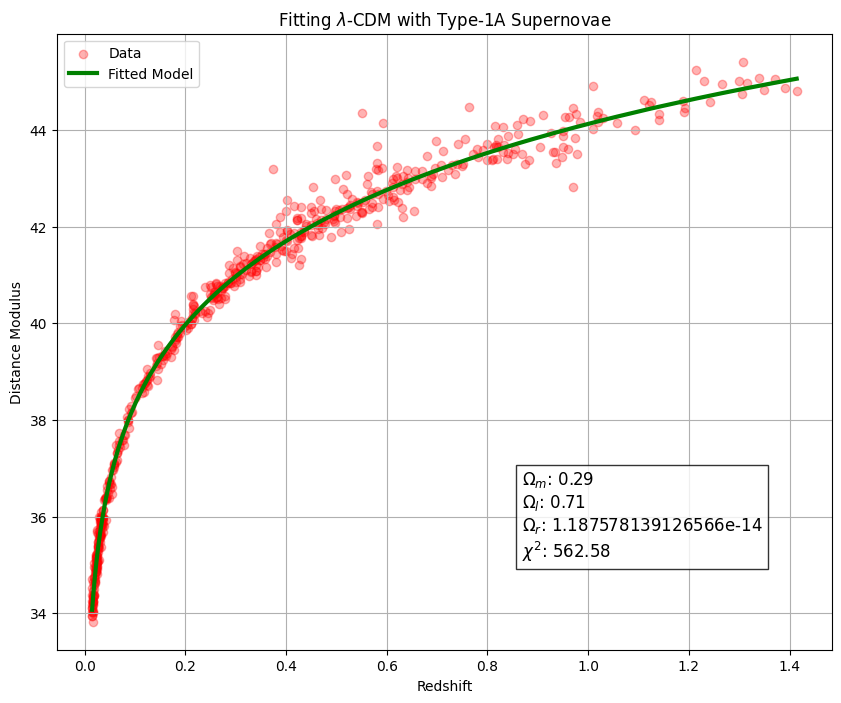

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(z_data, mu_data, color='red',alpha=0.3)
plt.plot(z_data,mu_pred, 'g-', linewidth=3)
plt.legend(['Data','Fitted Model'])
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Fitting $\lambda$-CDM with Type-1A Supernovae')
#plt.text(1.0,35,"$\chi^2$ = %s"%(chisq_est))
plt.grid(visible='True')

annotation = f'$\Omega_m$: {(result.x)[0]:.2f}\n$\Omega_l$: {(result.x)[1]:.2f}\n$\Omega_r$: {(result.x)[2]}\n$\chi^2$: {chisq_est:.2f}'
plt.annotate(annotation, xy=(0.6, 0.15), xycoords='axes fraction', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.savefig('/content/drive/MyDrive/DDP/Plot/LCDM_fit.png')

## Parameter Confidence Interval

In [ ]:
from scipy.optimize import approx_fprime

def hessian_matrix(params, z, mu, mu_err):
    gradient_func = lambda p: approx_fprime(p, lambda x: objective(x, z, mu, mu_err), epsilon=1e-6)
    hessian_matrix_approx = approx_fprime(params, gradient_func, epsilon=1e-6)
    return hessian_matrix_approx

In [ ]:
cov_matrix = np.linalg.inv(hessian_matrix(result.x, z_data, mu_data, mu_error_data))

In [ ]:
#We only need it for the first two parameters
cov_params = cov_matrix[:2,:2]

In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_params)
angle = np.degrees(np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1]))

In [ ]:
eigenvectors

array([[-0.42833433, -0.90362033],
       [-0.90362033,  0.42833433]])

In [ ]:
eigenvalues

array([0.00012637, 0.02122193])

In [ ]:
from scipy.stats import norm, chi2
def get_scaling_factor(num_sigmas):
    if num_sigmas <= 0:
        raise ValueError("Number of sigmas must be positive.")

    z_score = 1 - norm.pdf(num_sigmas)
    chi_value = chi2.ppf(z_score,2)
    # Chi-squared distribution quantile for 2 degrees of freedom
    scaling_factor = np.sqrt(chi_value)

    return scaling_factor

In [ ]:
def major_minor(num_sigmas, eigenvalues):
  scale_factor = get_scaling_factor(num_sigmas) # Adjust this scale factor as needed
  semi_major = scale_factor * np.sqrt(eigenvalues[1])
  semi_minor = scale_factor * np.sqrt(eigenvalues[0])

  return semi_major, semi_minor

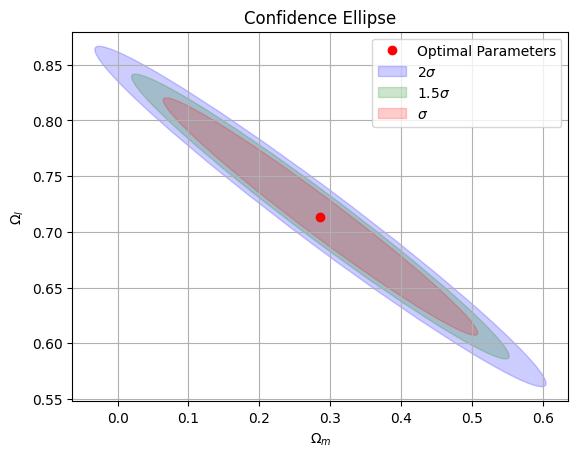

In [ ]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()

ax.plot((result.x)[0], (result.x)[1], 'ro', label='Optimal Parameters')  # Optimal parameters point

ellipse1 = Ellipse(
    ((result.x)[0], (result.x)[1]),
    width=(major_minor(1, eigenvalues))[0] * 2,
    height=(major_minor(1,eigenvalues))[1] * 2,
    angle=angle,
    color='red',
    alpha=0.2
)

ellipse2 = Ellipse(
    ((result.x)[0], (result.x)[1]),
    width=(major_minor(1.5,eigenvalues))[0] * 2,
    height=(major_minor(1.5,eigenvalues))[1] * 2,
    angle=angle,
    color='green',
    alpha=0.2
)

ellipse3 = Ellipse(
    ((result.x)[0], (result.x)[1]),
    width=(major_minor(2,eigenvalues))[0] * 2,
    height=(major_minor(2,eigenvalues))[1] * 2,
    angle=angle,
    color='blue',
    alpha=0.2
)


ax.add_patch(ellipse3)
ellipse3.set(label='2$\sigma$')

ax.add_patch(ellipse2)
ellipse2.set(label='1.5$\sigma$')

ax.add_patch(ellipse1)
ellipse1.set(label='$\sigma$')

#plt.xlim([0,1])
#plt.ylim([0,1])
plt.xlabel('$\Omega_m$')
plt.ylabel('$\Omega_l$')
plt.title('Confidence Ellipse')
plt.legend()
plt.grid()

plt.savefig('/content/drive/MyDrive/DDP/Plot/LCDM_sigma.png')